# IT585 Lab 1: Gradient Descent Variants

**Student Name:** Het Monpara  
**ID:** 202511016

---

## Section 1: Mathematical Derivations

### 1.1 Mean Squared Error (MSE)

**Loss Function:**
$$L(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^{n} (\mathbf{x}_i^T \mathbf{w} - y_i)^2$$

**Gradient:**
$$\nabla_\mathbf{w} L = \frac{2}{n} \mathbf{X}^T (\mathbf{X}\mathbf{w} - \mathbf{y})$$

### 1.2 Log-Cosh Loss

**Loss Function:**
$$L(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^{n} \log(\cosh(\mathbf{x}_i^T \mathbf{w} - y_i))$$

**Gradient:**
$$\nabla_\mathbf{w} L = \frac{1}{n} \mathbf{X}^T \tanh(\mathbf{X}\mathbf{w} - \mathbf{y})$$

### 1.3 Binary Focal Loss

**Loss Function:**
$$L(\mathbf{w}) = -\frac{1}{n} \sum_{i=1}^{n} \left[ (1-p_i)^\gamma y_i \log(p_i) + p_i^\gamma (1-y_i) \log(1-p_i) \right]$$

where $p_i = \sigma(\mathbf{x}_i^T \mathbf{w})$ and $\gamma = 2$

## Section 2: Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.preprocessing import StandardScaler
import time

np.random.seed(42)

### 2.1 Loss Functions

In [2]:
def mse_loss(w, X, y):
    predictions = X @ w
    return np.mean((predictions - y) ** 2)

def mse_grad(w, X, y):
    n = len(y)
    predictions = X @ w
    return (2.0 / n) * X.T @ (predictions - y)

def logcosh_loss(w, X, y):
    x = X @ w - y
    return np.mean(np.abs(x) + np.log1p(np.exp(-2 * np.abs(x))) - np.log(2.0))

def logcosh_grad(w, X, y):
    n = len(y)
    errors = X @ w - y
    return (1.0 / n) * X.T @ np.tanh(errors)

def sigmoid(z):
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

def binary_loss(w, X, y, gamma=2.0):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-8
    p = np.clip(p, eps, 1 - eps)
    loss = -(y * ((1 - p)**gamma) * np.log(p) + (1 - y) * (p**gamma) * np.log(1 - p))
    return np.mean(loss)

def binary_gradient(w, X, y, gamma=2.0):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    y_n = (y - y.min()) / (y.max() - y.min() + eps)
    
    term1 = y_n * (gamma * (1 - p)**(gamma - 1) * np.log(p) * p * (1-p) - (1 - p)**gamma / p * p * (1-p))
    term0 = (1 - y_n) * (-gamma * p**(gamma - 1) * np.log(1 - p) * p * (1-p) + p**gamma / (1 - p) * p * (1-p))
    dLdz = -(term1 + term0)
    grad = (X.T @ dLdz) / X.shape[0]
    return grad

### 2.2 Gradient Descent Methods

In [3]:
def batch_gradient_descent(X, y, loss_fn, grad_fn, lr=1e-4, epochs=200, w_init=None):
    w = np.zeros(X.shape[1]) if w_init is None else w_init.copy()
    path = [w.copy()]
    losses = [loss_fn(w, X, y)]
    times = [0.0]
    start_time = time.time()
    
    for epoch in range(epochs):
        grad = grad_fn(w, X, y)
        w = w - lr * grad
        path.append(w.copy())
        losses.append(loss_fn(w, X, y))
        times.append(time.time() - start_time)
    
    return np.array(path), np.array(losses), np.array(times)

def stochastic_gradient_descent(X, y, loss_fn, grad_fn, lr=1e-4, epochs=200, w_init=None):
    w = np.zeros(X.shape[1]) if w_init is None else w_init.copy()
    path = [w.copy()]
    losses = [loss_fn(w, X, y)]
    times = [0.0]
    n = len(y)
    start_time = time.time()
    
    for epoch in range(epochs):
        i = np.random.randint(n)
        X_sample = X[i:i+1]
        y_sample = y[i:i+1]
        grad = grad_fn(w, X_sample, y_sample)
        w = w - lr * grad
        path.append(w.copy())
        losses.append(loss_fn(w, X, y))
        times.append(time.time() - start_time)
    
    return np.array(path), np.array(losses), np.array(times)

def minibatch_gradient_descent(X, y, loss_fn, grad_fn, lr=1e-4, batch_size=32, epochs=200, w_init=None):
    w = np.zeros(X.shape[1]) if w_init is None else w_init.copy()
    path = [w.copy()]
    losses = [loss_fn(w, X, y)]
    times = [0.0]
    n = len(y)
    start_time = time.time()
    
    for epoch in range(epochs):
        indices = np.random.choice(n, size=min(batch_size, n), replace=False)
        X_batch = X[indices]
        y_batch = y[indices]
        grad = grad_fn(w, X_batch, y_batch)
        w = w - lr * grad
        path.append(w.copy())
        losses.append(loss_fn(w, X, y))
        times.append(time.time() - start_time)
    
    return np.array(path), np.array(losses), np.array(times)

### 2.3 Visualization Functions

In [4]:
def plot_convergence(losses_dict, title="Loss vs Iterations", use_log=False):
    plt.figure(figsize=(10, 6))
    for method, losses in losses_dict.items():
        plt.plot(losses, label=method, linewidth=2)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    if use_log:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

def plot_trajectories(paths_dict, X, y, loss_fn, title="Weight Trajectories", n_contours=30):
    n_methods = len(paths_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 6))
    if n_methods == 1:
        axes = [axes]
    
    all_paths = np.concatenate([p for p in paths_dict.values()])
    w1_min, w1_max = all_paths[:, 0].min(), all_paths[:, 0].max()
    w2_min, w2_max = all_paths[:, 1].min(), all_paths[:, 1].max()
    w1_margin = max(abs(w1_max - w1_min) * 0.2, 0.5)
    w2_margin = max(abs(w2_max - w2_min) * 0.2, 0.5)
    w1_range = (w1_min - w1_margin, w1_max + w1_margin)
    w2_range = (w2_min - w2_margin, w2_max + w2_margin)
    
    w1 = np.linspace(w1_range[0], w1_range[1], 100)
    w2 = np.linspace(w2_range[0], w2_range[1], 100)
    W1, W2 = np.meshgrid(w1, w2)
    
    Z = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            w = np.array([W1[i, j], W2[i, j]])
            Z[i, j] = loss_fn(w, X, y)
    
    colors = ['crimson', 'darkorange', 'forestgreen']
    
    for idx, (method, path) in enumerate(paths_dict.items()):
        ax = axes[idx]
        contourf = ax.contourf(W1, W2, Z, levels=20, cmap='viridis', alpha=0.4)
        contour = ax.contour(W1, W2, Z, levels=n_contours, cmap='viridis', alpha=0.8, linewidths=0.8)
        if idx == n_methods - 1:
            plt.colorbar(contourf, ax=ax, label='Loss')
        
        n_arrows = min(10, len(path) // 10)
        if n_arrows > 1:
            arrow_indices = np.linspace(0, len(path)-2, n_arrows, dtype=int)
            for i in arrow_indices:
                dx = path[i+1, 0] - path[i, 0]
                dy = path[i+1, 1] - path[i, 1]
                ax.arrow(path[i, 0], path[i, 1], dx, dy, head_width=0.05, head_length=0.05, fc=colors[idx % 3], ec=colors[idx % 3], alpha=0.6)
        
        ax.plot(path[:, 0], path[:, 1], 'o-', color=colors[idx % 3], linewidth=2, markersize=4, alpha=0.7, label='Trajectory')
        ax.plot(path[0, 0], path[0, 1], 'go', markersize=12, label='Start', zorder=5)
        ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15, label='End', zorder=5)
        
        ax.set_xlabel('w₁', fontsize=12)
        ax.set_ylabel('w₂', fontsize=12)
        ax.set_title(f'{method}', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 2.4 Dataset Generation

In [5]:
def generate_cigar_dataset(n_samples=1000, condition_number=100):
    X = np.random.randn(n_samples, 2)
    X[:, 0] *= condition_number
    true_w = np.array([2.0, -1.0])
    y = X @ true_w + np.random.randn(n_samples) * 0.1
    return X, y

def load_breast_cancer_dataset():
    data = load_breast_cancer()
    X = data.data[:, :2]
    y = data.target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def load_housing_dataset(n_samples=5000):
    data = fetch_california_housing()
    X = data.data[:n_samples, :2]
    y = data.target[:n_samples]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

## Section 3: Experiments

### 3.1 Cigar Dataset with MSE Loss

Cigar Dataset - MSE Loss
Batch GD - Final Loss: 0.957032
SGD - Final Loss: 1.060337
Mini-Batch GD - Final Loss: 1.350150


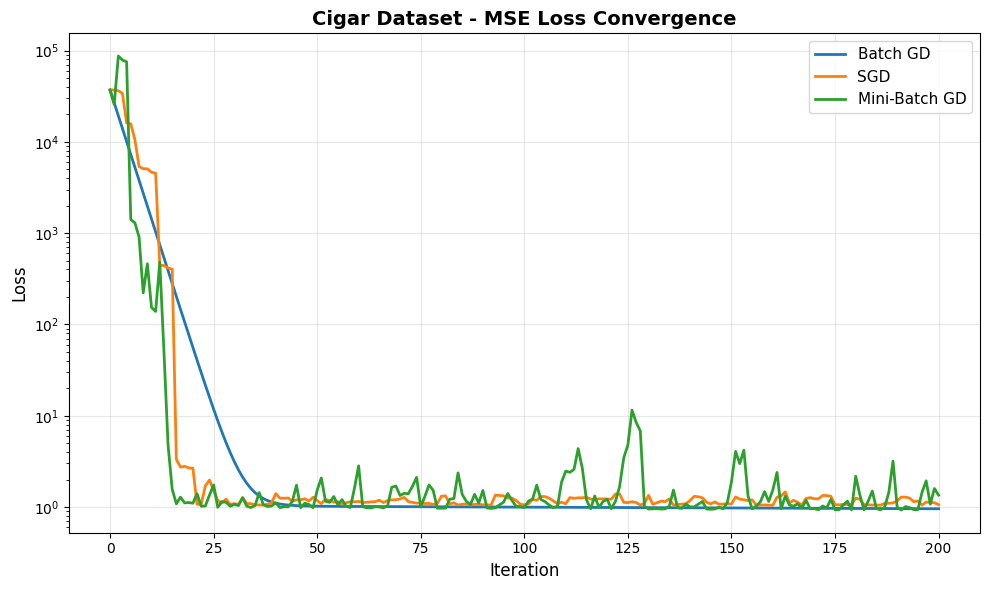

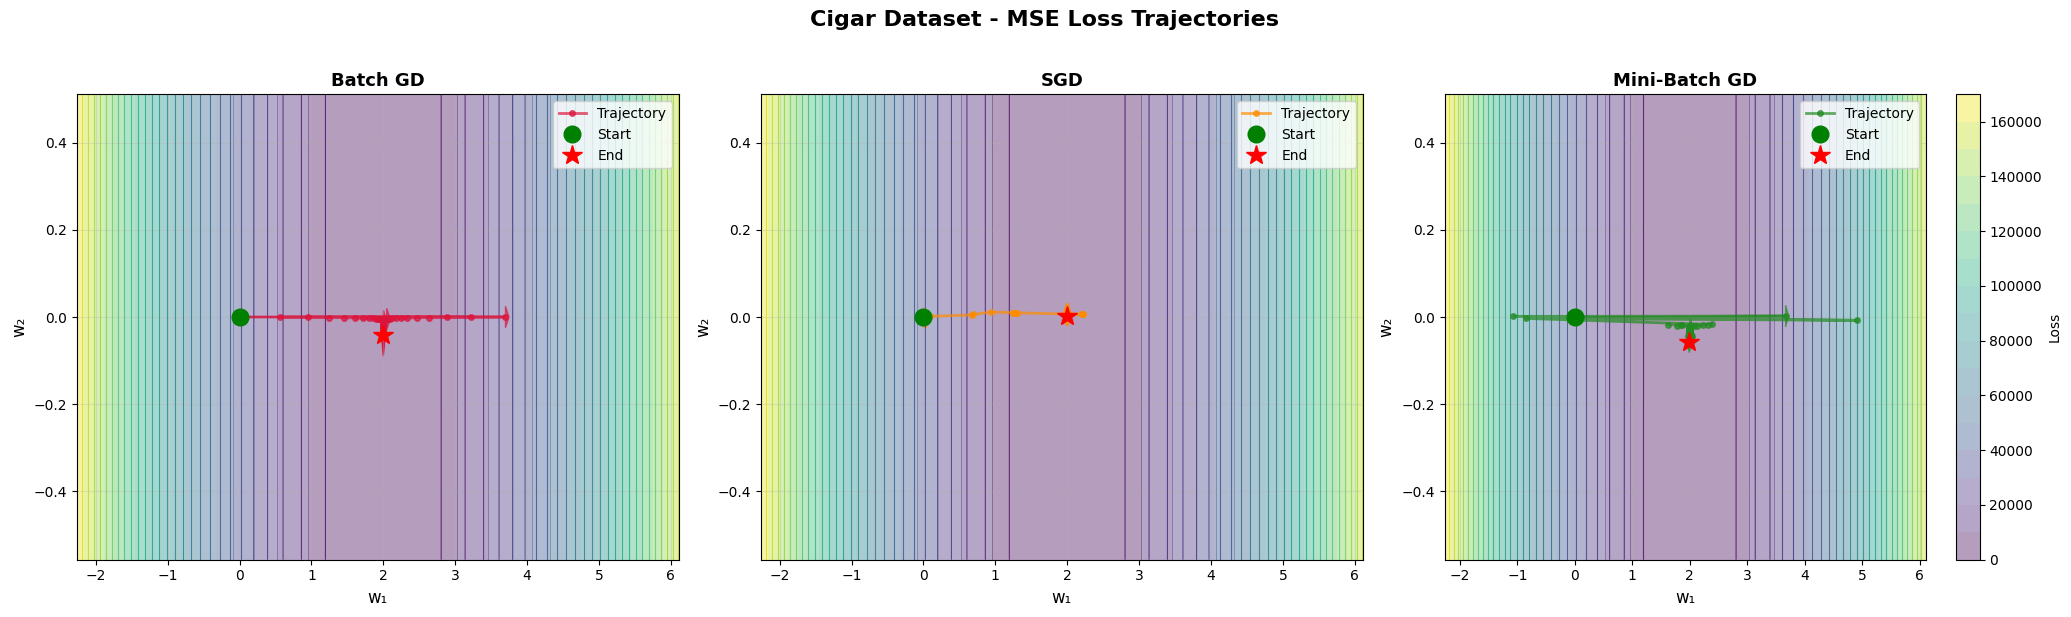

In [ ]:
X_cigar, y_cigar = generate_cigar_dataset(n_samples=1000, condition_number=100)

print("Cigar Dataset - MSE Loss")
print("="*50)

path_bgd, loss_bgd, time_bgd = batch_gradient_descent(X_cigar, y_cigar, mse_loss, mse_grad, lr=1e-4, epochs=200)
path_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(X_cigar, y_cigar, mse_loss, mse_grad, lr=1e-5, epochs=200)
path_mbgd, loss_mbgd, time_mbgd = minibatch_gradient_descent(X_cigar, y_cigar, mse_loss, mse_grad, lr=1e-4, batch_size=32, epochs=200)

print(f"Batch GD - Final Loss: {loss_bgd[-1]:.6f}")
print(f"SGD - Final Loss: {loss_sgd[-1]:.6f}")
print(f"Mini-Batch GD - Final Loss: {loss_mbgd[-1]:.6f}")

losses_dict = {'Batch GD': loss_bgd, 'SGD': loss_sgd, 'Mini-Batch GD': loss_mbgd}
plot_convergence(losses_dict, title="Cigar Dataset - MSE Loss Convergence", use_log=True)

paths_dict = {'Batch GD': path_bgd, 'SGD': path_sgd, 'Mini-Batch GD': path_mbgd}
plot_trajectories(paths_dict, X_cigar, y_cigar, mse_loss, title="Cigar Dataset - MSE Loss Trajectories")

### 3.2 Cigar Dataset with Log-Cosh Loss


Cigar Dataset - Log-Cosh Loss
Batch GD - Final Loss: 2.209563
SGD - Final Loss: 39.322684
Mini-Batch GD - Final Loss: 3.134305


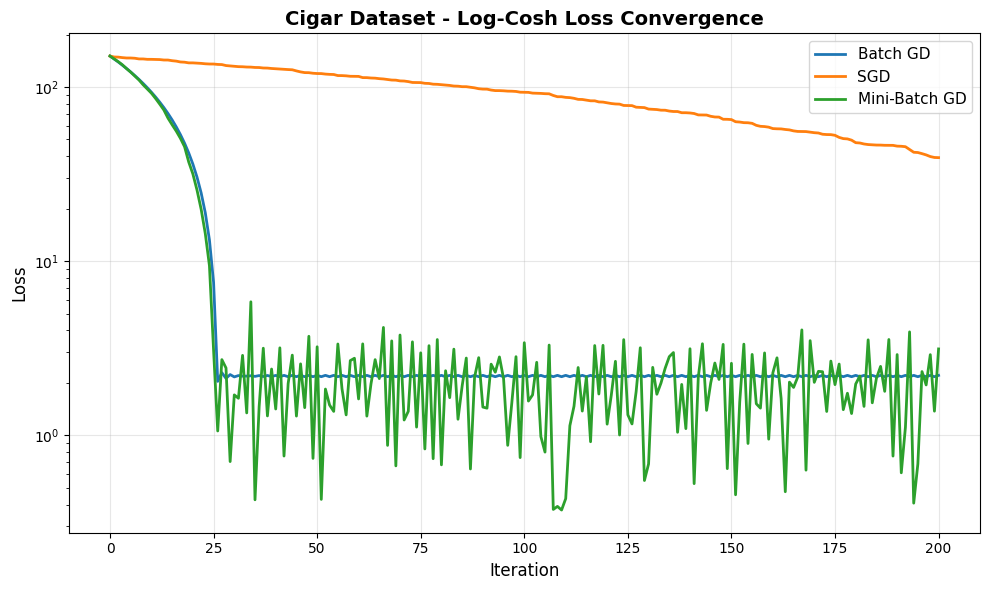

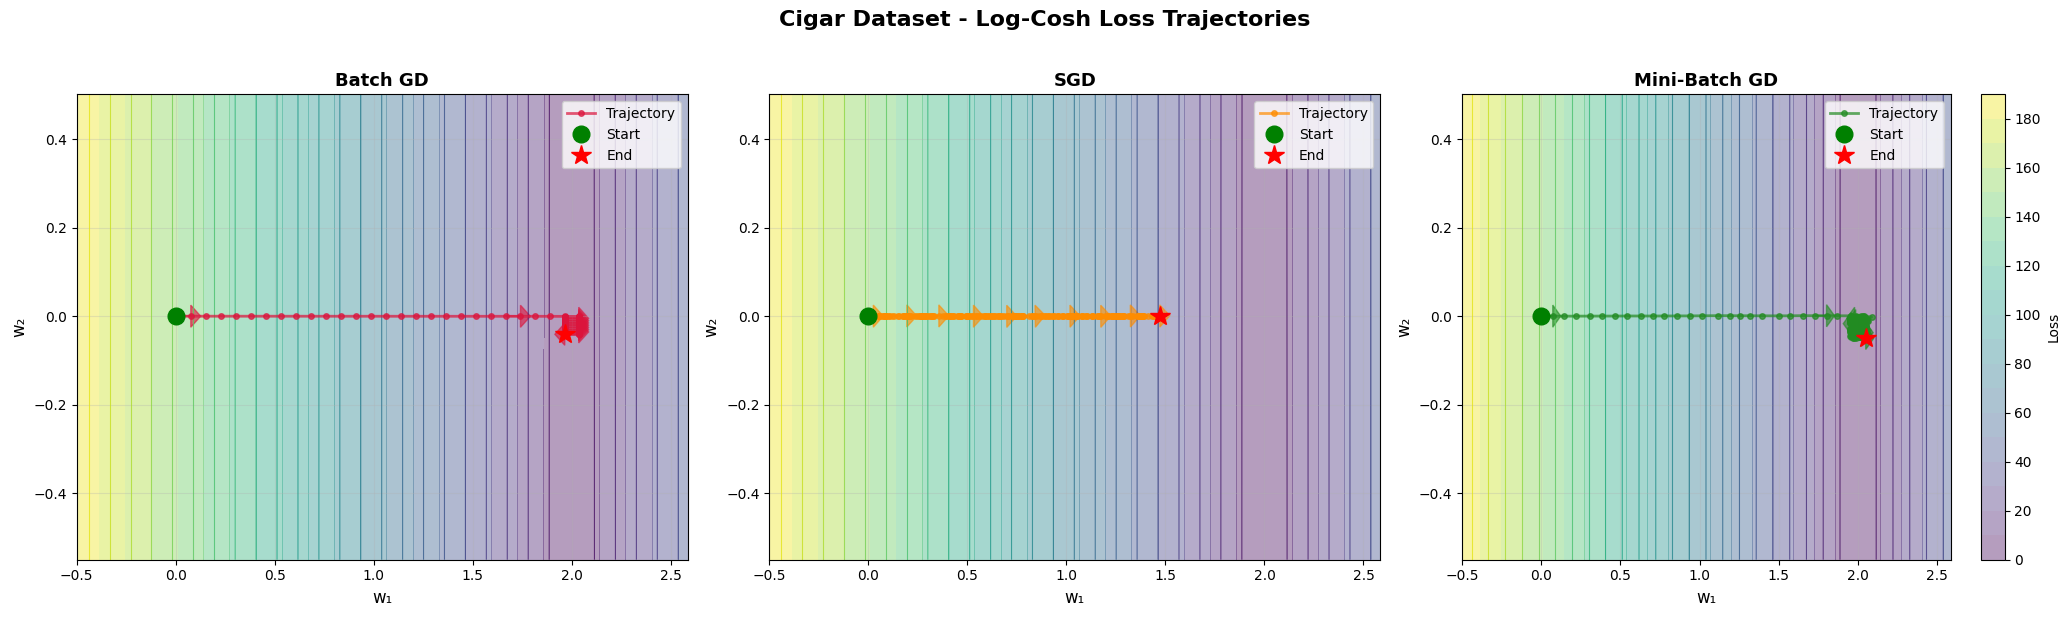

In [ ]:
print("\nCigar Dataset - Log-Cosh Loss")
print("="*50)

path_bgd_lc, loss_bgd_lc, time_bgd_lc = batch_gradient_descent(X_cigar, y_cigar, logcosh_loss, logcosh_grad, lr=1e-3, epochs=200)
path_sgd_lc, loss_sgd_lc, time_sgd_lc = stochastic_gradient_descent(X_cigar, y_cigar, logcosh_loss, logcosh_grad, lr=1e-4, epochs=200)
path_mbgd_lc, loss_mbgd_lc, time_mbgd_lc = minibatch_gradient_descent(X_cigar, y_cigar, logcosh_loss, logcosh_grad, lr=1e-3, batch_size=32, epochs=200)

print(f"Batch GD - Final Loss: {loss_bgd_lc[-1]:.6f}")
print(f"SGD - Final Loss: {loss_sgd_lc[-1]:.6f}")
print(f"Mini-Batch GD - Final Loss: {loss_mbgd_lc[-1]:.6f}")

losses_dict_lc = {'Batch GD': loss_bgd_lc, 'SGD': loss_sgd_lc, 'Mini-Batch GD': loss_mbgd_lc}
plot_convergence(losses_dict_lc, title="Cigar Dataset - Log-Cosh Loss Convergence", use_log=True)

paths_dict_lc = {'Batch GD': path_bgd_lc, 'SGD': path_sgd_lc, 'Mini-Batch GD': path_mbgd_lc}
plot_trajectories(paths_dict_lc, X_cigar, y_cigar, logcosh_loss, title="Cigar Dataset - Log-Cosh Loss Trajectories")

### 3.3 Breast Cancer Dataset with Focal Loss


Breast Cancer Dataset - Focal Loss
Batch GD - Final Loss: 0.617171
SGD - Final Loss: 0.175842
Mini-Batch GD - Final Loss: 0.608795


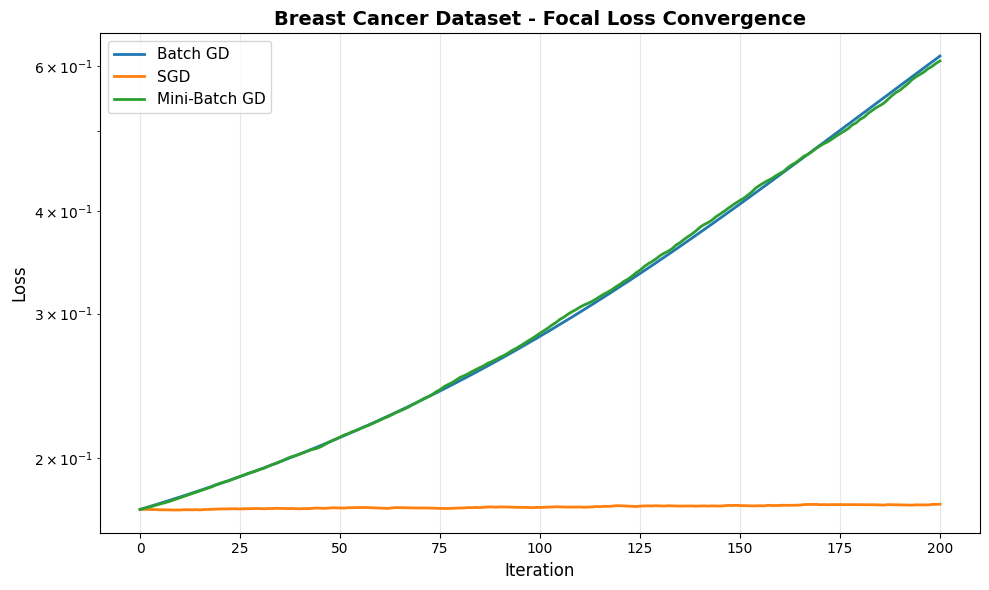

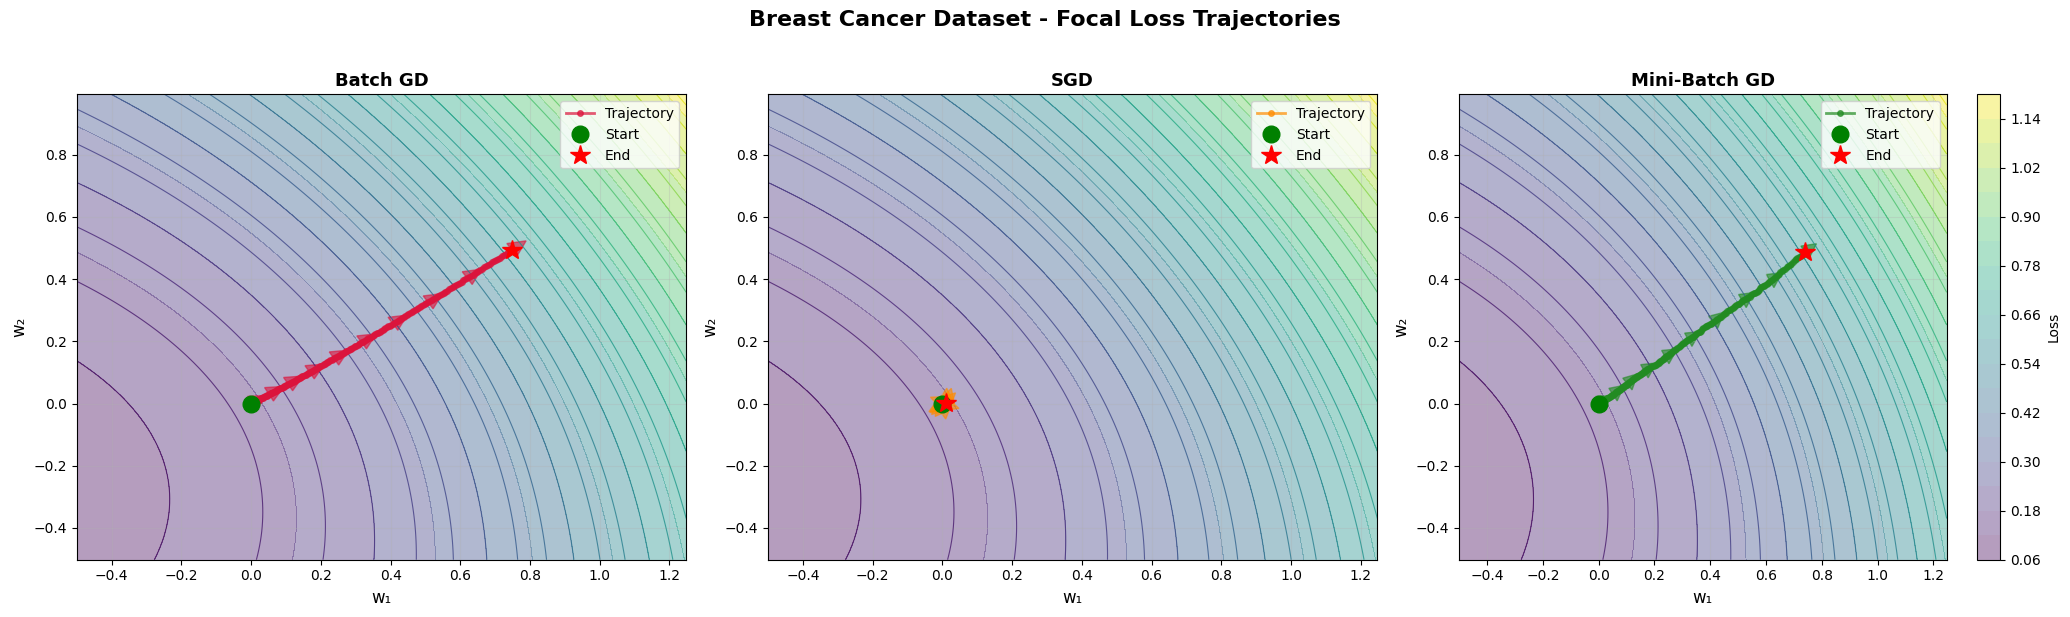

In [ ]:
X_cancer, y_cancer = load_breast_cancer_dataset()

print("\nBreast Cancer Dataset - Focal Loss")
print("="*50)

path_bgd_bc, loss_bgd_bc, time_bgd_bc = batch_gradient_descent(X_cancer, y_cancer, binary_loss, binary_gradient, lr=1e-2, epochs=200)
path_sgd_bc, loss_sgd_bc, time_sgd_bc = stochastic_gradient_descent(X_cancer, y_cancer, binary_loss, binary_gradient, lr=1e-3, epochs=200)
path_mbgd_bc, loss_mbgd_bc, time_mbgd_bc = minibatch_gradient_descent(X_cancer, y_cancer, binary_loss, binary_gradient, lr=1e-2, batch_size=32, epochs=200)

print(f"Batch GD - Final Loss: {loss_bgd_bc[-1]:.6f}")
print(f"SGD - Final Loss: {loss_sgd_bc[-1]:.6f}")
print(f"Mini-Batch GD - Final Loss: {loss_mbgd_bc[-1]:.6f}")

losses_dict_bc = {'Batch GD': loss_bgd_bc, 'SGD': loss_sgd_bc, 'Mini-Batch GD': loss_mbgd_bc}
plot_convergence(losses_dict_bc, title="Breast Cancer Dataset - Focal Loss Convergence", use_log=True)

paths_dict_bc = {'Batch GD': path_bgd_bc, 'SGD': path_sgd_bc, 'Mini-Batch GD': path_mbgd_bc}
plot_trajectories(paths_dict_bc, X_cancer, y_cancer, binary_loss, title="Breast Cancer Dataset - Focal Loss Trajectories")

### 3.4 Housing Dataset with MSE Loss


Housing Dataset - MSE Loss
Batch GD - Final Loss: 3.723155
SGD - Final Loss: 3.963323
Mini-Batch GD - Final Loss: 3.724442


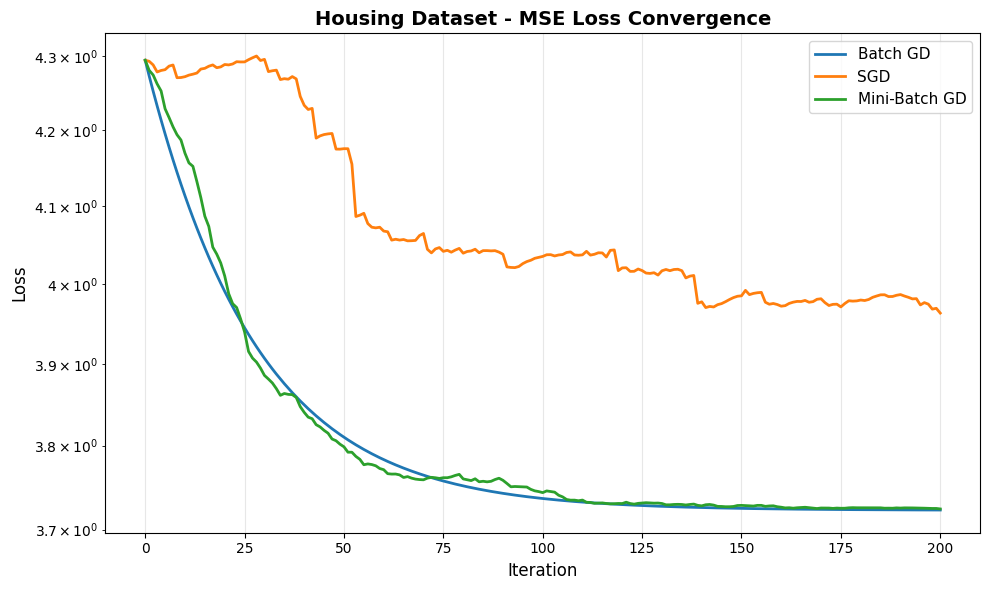

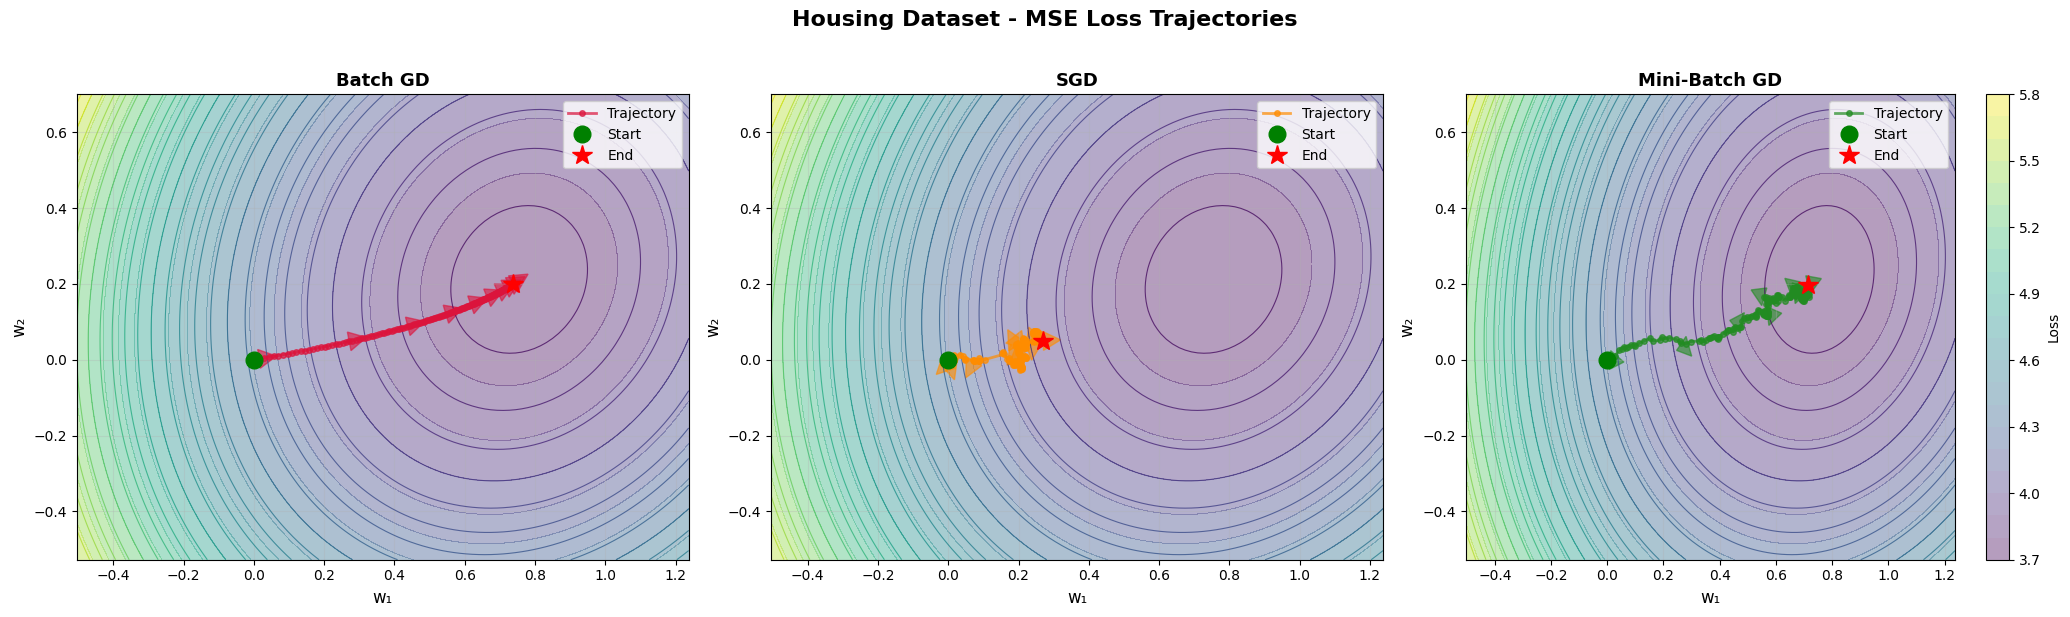

In [ ]:
X_housing, y_housing = load_housing_dataset(n_samples=5000)

print("\nHousing Dataset - MSE Loss")
print("="*50)

path_bgd_h, loss_bgd_h, time_bgd_h = batch_gradient_descent(X_housing, y_housing, mse_loss, mse_grad, lr=1e-2, epochs=200)
path_sgd_h, loss_sgd_h, time_sgd_h = stochastic_gradient_descent(X_housing, y_housing, mse_loss, mse_grad, lr=1e-3, epochs=200)
path_mbgd_h, loss_mbgd_h, time_mbgd_h = minibatch_gradient_descent(X_housing, y_housing, mse_loss, mse_grad, lr=1e-2, batch_size=64, epochs=200)

print(f"Batch GD - Final Loss: {loss_bgd_h[-1]:.6f}")
print(f"SGD - Final Loss: {loss_sgd_h[-1]:.6f}")
print(f"Mini-Batch GD - Final Loss: {loss_mbgd_h[-1]:.6f}")

losses_dict_h = {'Batch GD': loss_bgd_h, 'SGD': loss_sgd_h, 'Mini-Batch GD': loss_mbgd_h}
plot_convergence(losses_dict_h, title="Housing Dataset - MSE Loss Convergence", use_log=True)

paths_dict_h = {'Batch GD': path_bgd_h, 'SGD': path_sgd_h, 'Mini-Batch GD': path_mbgd_h}
plot_trajectories(paths_dict_h, X_housing, y_housing, mse_loss, title="Housing Dataset - MSE Loss Trajectories")

## Section 4: Analysis

### 4.1 Dataset Characteristics

In [ ]:
def compute_condition_number(X):
    XTX = X.T @ X
    eigenvalues = np.linalg.eigvalsh(XTX)
    return np.max(eigenvalues) / np.min(eigenvalues)

print("\nDataset Comparison")
print("="*80)
print(f"{'Property':<30} {'Cigar':<20} {'Breast Cancer':<20} {'Housing':<15}")
print("-"*80)
print(f"{'Number of samples':<30} {len(X_cigar):<20} {len(X_cancer):<20} {len(X_housing):<15}")
print(f"{'Condition Number':<30} {compute_condition_number(X_cigar):<20.2e} {compute_condition_number(X_cancer):<20.2f} {compute_condition_number(X_housing):<15.2f}")
print(f"{'Feature 1 Std':<30} {np.std(X_cigar[:, 0]):<20.2f} {np.std(X_cancer[:, 0]):<20.2f} {np.std(X_housing[:, 0]):<15.2f}")
print(f"{'Feature 2 Std':<30} {np.std(X_cigar[:, 1]):<20.2f} {np.std(X_cancer[:, 1]):<20.2f} {np.std(X_housing[:, 1]):<15.2f}")
print("="*80)


Dataset Comparison
Property                       Cigar                Breast Cancer        Housing        
--------------------------------------------------------------------------------
Number of samples              1000                 569                  5000           
Condition Number               8.96e+03             1.96                 1.31           
Feature 1 Std                  96.11                1.00                 1.00           
Feature 2 Std                  1.01                 1.00                 1.00           


### 4.2 Key Observations

1. **Cigar Dataset**: High condition number makes optimization difficult
2. **Real Datasets**: Lower condition numbers lead to faster convergence
3. **Batch GD**: Most stable but slower
4. **SGD**: Faster but more noisy
5. **Mini-Batch GD**: Good balance between speed and stability